In [280]:

import os
import json
import random
from typing import List, Tuple, Dict
from collections import defaultdict
import numpy as np
import matplotlib.pyplot as plt
from matplotlib.patches import Rectangle
import mmcv
from mmdet.apis import init_detector, inference_detector
from mmengine.registry import init_default_scope
from mmdet.registry import VISUALIZERS
# from mmdet.apis import register_all_modules


In [281]:

# Update these paths according to your setup
CONFIG_FILE = '../configs/yolov8/yolov8_x.py'  # Your model config file
CHECKPOINT_FILE = '../yolo8_label_2_0603_12_27/label-2/yolov8_x_fold_1/best_coco_bbox_mAP_epoch_40.pth'  # Your model weights
IMG_DIR = '/media/klee_ro/public_datasets/vindr_cxr/train/'  # Directory containing images
ANNOTATION_FILE = '../data/ann_agreement_orig/label-2/train_fold_2.json'  # Directory containing ground truth annotations

# Define your class names
CLASSES = [
    "Aortic enlargement", "Atelectasis", "Calcification", "Cardiomegaly", "Consolidation", "ILD",
           "Infiltration", "Lung Opacity", "Nodule/Mass", "Other lesion", "Pleural effusion", "Pleural thickening",
           "Pneumothorax", "Pulmonary fibrosis"
]

class MedicalDetectionVisualizer:
    """Visualizer class for medical object detection results with multi-radiologist COCO format support."""

    def __init__(self,
                 config_file: str,
                 checkpoint_file: str,
                 class_names: List[str],
                 annotation_file: str,
                 score_threshold: float = 0.3):
        """
        Initialize the visualizer.

        Args:
            config_file: Path to model config file
            checkpoint_file: Path to model weights
            class_names: List of class names
            annotation_file: Path to COCO format annotation file
            score_threshold: Confidence threshold for predictions
        """
        # register_all_modules()
        self.model = init_detector(config_file, checkpoint_file, device='cuda:0')
        self.class_names = class_names
        self.score_threshold = score_threshold
        self.colors = self._generate_colors(len(class_names))

        # Load and process COCO annotations
        self.annotations = self._load_coco_annotations(annotation_file)

    def _generate_colors(self, n_classes: int) -> List[Tuple[float, float, float]]:
        """Generate distinct colors for visualization."""
        colors = []
        for i in range(n_classes):
            hue = i / n_classes
            colors.append(plt.cm.hsv(hue)[:3])
        return colors

    def _load_coco_annotations(self, annotation_file: str) -> Dict:
        """
        Load and process COCO format annotations, organizing by radiologist.

        Returns:
            Dictionary with processed annotations organized by image_id and radiologist
        """
        with open(annotation_file, 'r') as f:
            coco_data = json.load(f)

        # Create lookup dictionaries
        images_dict = {img['id']: img for img in coco_data['images']}
        categories_dict = {cat['id']: cat['name'] for cat in coco_data['categories']}

        # Organize annotations by image and radiologist
        annotations_by_image = defaultdict(lambda: defaultdict(list))
        
        for ann in coco_data['annotations']:
            image_id = ann['image_id']
            image_info = images_dict[image_id]
            
            # Process each radiologist's annotation separately
            for rad_id in ann['rad_ids']:
                # Store annotation with normalized coordinates
                bbox = ann['bbox']  # [x, y, width, height]
                x1, y1, w, h = bbox

                # Convert to normalized coordinates if needed
                if max(x1, y1, w, h) > 1:
                    x1 /= image_info['width']
                    y1 /= image_info['height']
                    w /= image_info['width']
                    h /= image_info['height']

                annotations_by_image[image_info['file_name']][rad_id].append({
                    'bbox': [x1, y1, w, h],
                    'category_id': ann['category_id']
                })

        return annotations_by_image

    def visualize_batch(self,
                       img_dir: str,
                       num_images: int = 4,
                       figsize: Tuple[int, int] = (25, 15)) -> None:
        """
        Visualize ground truth from all radiologists and predictions for multiple images.

        Args:
            img_dir: Directory containing images
            num_images: Number of images to visualize
            figsize: Figure size for the plot
        """
        # Get images that have annotations
        available_images = list(set(os.listdir(img_dir)) & set(self.annotations.keys()))
        selected_images = random.sample(available_images, num_images)

        for img_name in selected_images:
            # Create a figure with subplots for each radiologist plus predictions
            rad_ids = list(self.annotations[img_name].keys())
            n_plots = len(rad_ids) + 1  # radiologists + predictions
            fig, axes = plt.subplots(1, n_plots, figsize=figsize)
            
            # Handle case when there's only one radiologist
            if n_plots == 2:
                axes = np.array([axes])
            
            # Load image
            img_path = os.path.join(img_dir, img_name)
            img = mmcv.imread(img_path)
            h, w, _ = img.shape

            # Plot ground truth for each radiologist
            for idx, rad_id in enumerate(rad_ids):
                gt_boxes = self._process_gt_annotations(img_name, rad_id, h, w)
                self._plot_single_image(axes[idx], img,
                                      gt_boxes,
                                      f"Ground Truth (Radiologist: {rad_id})")

            # Get and plot predictions
            result = inference_detector(self.model, img_path)
            pred_boxes = self._format_predictions(result)
            self._plot_single_image(axes[-1], img,
                                  pred_boxes,
                                  "Model Predictions")

            plt.suptitle(f"Image: {img_name}", y=0.95, fontsize=28)
            plt.tight_layout()
            plt.show()

    def _process_gt_annotations(self, img_name: str, rad_id: str, height: int, width: int) -> List[Tuple]:
        """Process ground truth annotations for an image from a specific radiologist."""
        boxes_and_classes = []
        for ann in self.annotations[img_name][rad_id]:
            x, y, w, h = ann['bbox']

            # Convert to absolute coordinates
            x1 = x * width
            y1 = y * height
            x2 = (x + w) * width
            y2 = (y + h) * height

            boxes_and_classes.append(([x1, y1, x2, y2], ann['category_id'], None))
        return boxes_and_classes

    def _plot_single_image(self,
                          ax: plt.Axes,
                          img: np.ndarray,
                          boxes_and_classes: List[Tuple],
                          title: str) -> None:
        """Plot single image with bounding boxes."""
        ax.imshow(mmcv.bgr2rgb(img))
        ax.set_title(title, fontsize=24) 
        
        # Sort boxes by y-coordinate (top to bottom)
        boxes_and_classes.sort(key=lambda x: x[0][1])
        
        # Track label positions to avoid overlaps
        label_positions = []
        
        for box, class_id, score in boxes_and_classes:
            x1, y1, x2, y2 = box
            rect = Rectangle((x1, y1), x2-x1, y2-y1,
                        fill=False, edgecolor=self.colors[class_id], linewidth=2)
            ax.add_patch(rect)
            
            label = f'{self.class_names[class_id]}'
            if score is not None:
                label += f' {score:.2f}'
            
            # Default position: right side of box
            label_x = x1
            label_y = y1 - 50
            
            # Adjust position if overlapping existing labels
            for i in range(len(label_positions)):
                existing_x, existing_y = label_positions[i]
                if abs(label_y - existing_y) < 50 or abs(label_x - existing_x) < 200:  # If too close vertically
                    label_y = label_y + 150  # Move down
                    
            # Add label with connection line
            # ax.plot([x2, label_x], [(y1+y2)/2, label_y], 
            #     color=self.colors[class_id], linestyle='--', linewidth=1)
            ax.text(label_x, label_y, label,
                color='black', fontsize=18, verticalalignment='center',
                bbox=dict(facecolor='white', alpha=0.9))
            
            label_positions.append((label_x, label_y))
        
        ax.axis('off')

    def _position_overlaps(self, pos, used_positions, min_dist=200):
        """Check if a position overlaps with existing labels"""
        for used in used_positions:
            if ((pos[0]-used[0])**2 + (pos[1]-used[1])**2)**0.5 < min_dist:
                return True
        return False

    def _format_predictions(self, det_data_sample) -> List[Tuple]:
        """
        Format model predictions from DetDataSample format.
        
        Args:
            det_data_sample: Detection results in DetDataSample format
            
        Returns:
            List of tuples containing (bbox, class_id, score)
        """
        boxes_and_classes = []
        
        # Extract predictions from DetDataSample
        pred_instances = det_data_sample.pred_instances
        
        # Get bounding boxes, labels and scores
        bboxes = pred_instances.bboxes.cpu().numpy()
        labels = pred_instances.labels.cpu().numpy()
        scores = pred_instances.scores.cpu().numpy()
        
        # Process each prediction
        for bbox, label, score in zip(bboxes, labels, scores):
            if score >= self.score_threshold:
                boxes_and_classes.append((bbox, label, score))
                
        return boxes_and_classes

In [282]:
# Initialize the visualizer with your configuration
visualizer = MedicalDetectionVisualizer(
    config_file=CONFIG_FILE,
    checkpoint_file=CHECKPOINT_FILE,
    class_names=CLASSES,
    annotation_file=ANNOTATION_FILE
)

Loads checkpoint by local backend from path: ../yolo8_label_2_0603_12_27/label-2/yolov8_x_fold_1/best_coco_bbox_mAP_epoch_40.pth


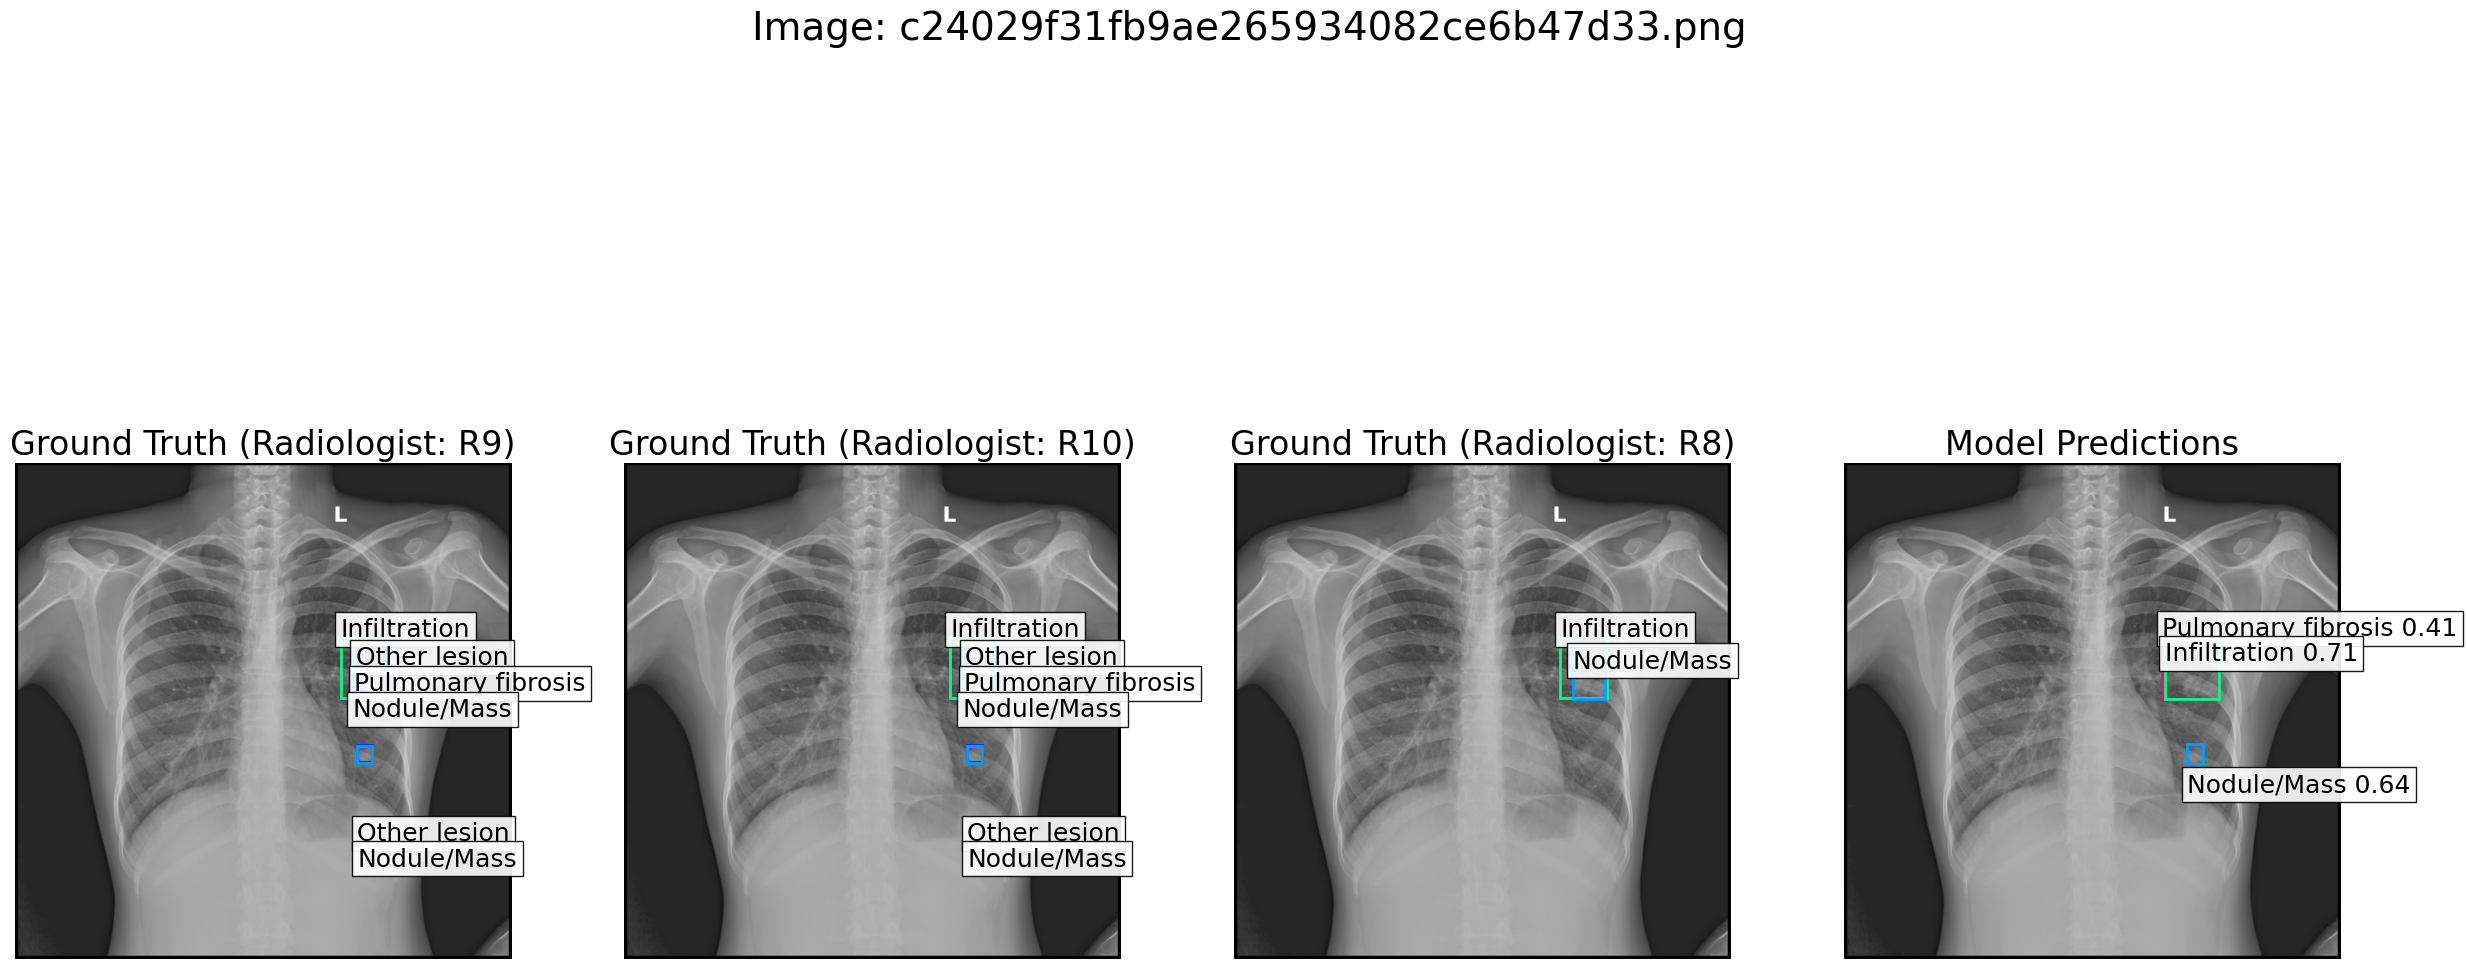

In [291]:
# Visualize 4 random images (change num_images parameter to visualize different number of images)
visualizer.visualize_batch(
    img_dir=IMG_DIR,
    num_images=1
)